In [1]:
%pip install torchinfo

# Histopathologic Cancer Detection
This Kaggle dataset includes medical images of biopsies under microscope. They are labeled malignant and non-malignant.

The challenge is to assess the center 32x32 crop of each image and label it for cancer.

I chose to expand the cropped region to gain more information to make the assesment with.

### Global Parameters

In [2]:
# current date time YYYY_MM_DD_HH_MM_SS
import datetime
now = datetime.datetime.now()
current_time = now.strftime("%Y_%m_%d_%H_%M_%S")
crop_dimensions = (48,48)
resize_size = (96,96)
early_stopping_patience = 10
early_stopping_delta = 0.005
batch_size = 128
num_workers = 5
dropout_prob = 0.1
training_samples = 8000 # the dataset is massive, using a smaller size for comparisons between models.
batch_status_interval = 10 # how often to print batch progress during training

message = f"Date: {current_time}; Time: {current_time}; Crop Dimensions: {crop_dimensions}; Resize Dimensions: {resize_size}; Batch Size: {batch_size}; Dropout: {dropout_prob}; Training Samples: {training_samples}; "

In [3]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from torchinfo import summary

In [4]:
def download_data_from_kaggle():
    """
    Downloads the dataset from Kaggle and unzips it.
    Assumes using Colab or environment variables KAGGLE_USERNAME
    and KAGGLE_KEY are set.
    """
    print("Downloading data from Kaggle...")
    # Colab-specific: only use these if running on Google Colab
    try:
        from google.colab import userdata
        os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')
        os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
    except ImportError:
        from dotenv import load_dotenv
        load_dotenv()

    # Download via Kaggle API
    os.system("kaggle competitions download -c histopathologic-cancer-detection")
    print("Download complete")

def unzip_data():
    """
    Unzips the downloaded dataset.
    """
    print("Unzipping data...")
    os.system("unzip -nq histopathologic-cancer-detection.zip")
    print("Unzip complete")

In [5]:
download_data_from_kaggle()
unzip_data()

Download complete
Unzipping data...
Unzip complete


In [6]:
train_dir = 'train'
test_dir = 'test'
csv_path = 'train_labels.csv'

In [7]:
# Load labels
labels = pd.read_csv(csv_path)

# Target Balance
The dataset is moderately imbalanced favoring non-cancerous samples.

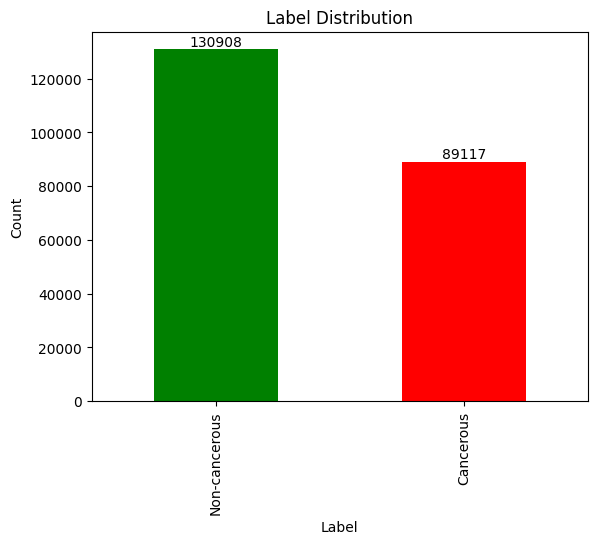

In [8]:
noncancerous, cancerous = labels['label'].value_counts()
# green for noncancerous red for cancer
labels['label'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(range(2), ['Non-cancerous', 'Cancerous'])
plt.text(0, noncancerous, str(noncancerous), ha='center', va='bottom')
plt.text(1, cancerous, str(cancerous), ha='center', va='bottom')
plt.show()

# Rebalance the dataset
We'll take a sample of 80000 of each target for a total size of 160000 samples.

<ipython-input-9-8d797a3dd052>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_labels = labels.groupby('label').apply(lambda x: x.sample(training_samples // 2)).reset_index(drop=True)


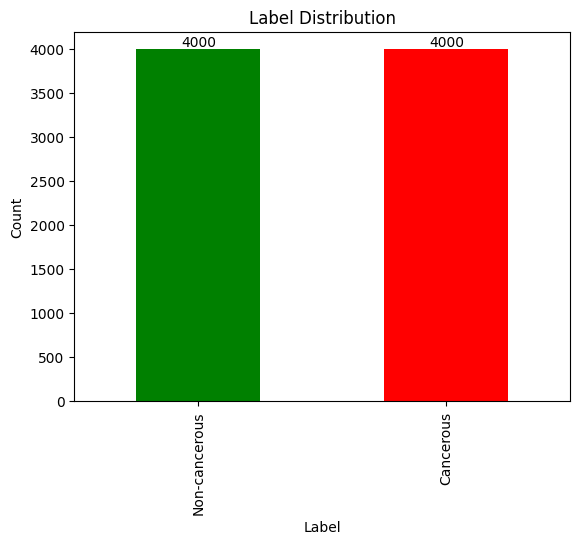

In [9]:
balanced_labels = labels.groupby('label').apply(lambda x: x.sample(training_samples // 2)).reset_index(drop=True)

noncancerous, cancerous = balanced_labels['label'].value_counts()
# green for noncancerous red for cancer
balanced_labels['label'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(range(2), ['Non-cancerous', 'Cancerous'])
plt.text(0, noncancerous, str(noncancerous), ha='center', va='bottom')
plt.text(1, cancerous, str(cancerous), ha='center', va='bottom')
plt.show()

# Split into training and validation sets
train_labels, val_labels = train_test_split(balanced_labels, test_size=0.2, random_state=42)

# Examples of Samples

<ipython-input-10-1bd3968fc279>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cancer = balanced_labels[labels['label'] == 1]
<ipython-input-10-1bd3968fc279>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  noncancer = balanced_labels[labels['label'] == 0]


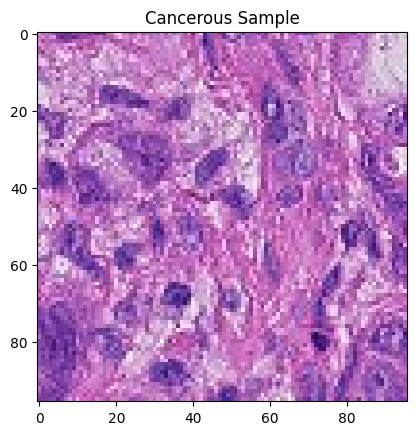

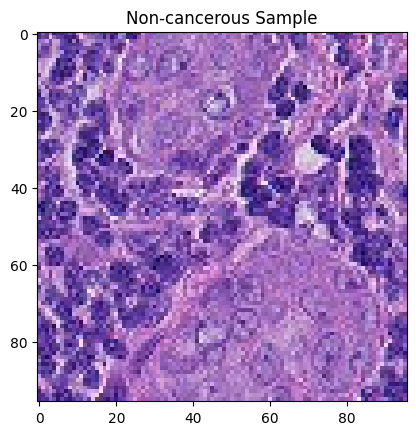

In [10]:
cancer = balanced_labels[labels['label'] == 1]
noncancer = balanced_labels[labels['label'] == 0]

cancer_sample = cancer.sample(1)
noncancer_sample = noncancer.sample(1)

cancer_sample_id = cancer_sample.iloc[0, 0]
noncancer_sample_id = noncancer_sample.iloc[0, 0]

plt.imshow(Image.open(train_dir + '/' + cancer_sample_id + '.tif'))
plt.title('Cancerous Sample')
plt.show()

plt.imshow(Image.open(train_dir + '/' + noncancer_sample_id + '.tif'))
plt.title('Non-cancerous Sample')
plt.show()


# Using Pytorch
I opted to learn Pytorch for this challenge.

Below is a dataset class used to represent the training and validation sets later.

In [11]:
class ImageDataset(Dataset):
    def __init__(self, labels, image_folder, transform=None):
        self.labels = labels
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Get image path and label
        img_name = os.path.join(self.image_folder, self.labels.iloc[idx, 0])
        label = self.labels.iloc[idx, 1]

        # Open and transform image
        image = Image.open(img_name + ".tif").convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.float32)
        return image, label


# Training With Dataset Statistics
When training, normalizing based on dataset mean and standard deviation improves convergence and stability.

When retraining a pretrained model like ResNet18, the original dataset statistics can be used.

Where I used ResNet18 as a basis, I opted to retrain the entire set of weights. As such, I calculated the statistics for this dataset.

Where I made my own simpler model both with and without residual layers, I used these statistics.

In [12]:
# Statistics
stats_transform = transforms.Compose([
    transforms.CenterCrop(crop_dimensions),
    transforms.Resize(resize_size),
    transforms.ToTensor()
])
train_dataset = ImageDataset(train_labels, train_dir, transform=stats_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

mean = 0
std = 0
total_images = 0

if mean == 0.0 and std == 0.0:
    print("Calculating mean and std...")
    for images, _ in train_loader:
        # images has shape (batch_size, 3, H, W)
        # Reshape the batch to (batch_size, 3, H*W)
        batch_size = images.shape[0]
        images = images.view(batch_size, images.shape[1], -1)  # (batch_size, 3, H*W)

        # Compute mean and std *per channel* over pixels, then sum over batch
        # mean across dimension=2 (pixels), resulting in shape (batch_size, 3)
        mean += images.mean(dim=2).sum(dim=0)
        std += images.std(dim=2).sum(dim=0)
        # total_images += batch_size
        # final batch my != batch_size
        total_images += images.shape[0]

        # Unbalanced Input to Train Test Split
        # Calculated mean:  tensor([0.7025, 0.5452, 0.6961])
        # Calculated std:  tensor([0.1536, 0.1702, 0.1357])

        # With Balanced Input to Train Test Split
        # Calculated mean:  tensor([0.7014, 0.5389, 0.6954])
        # Calculated std:  tensor([0.1511, 0.1670, 0.1322])
    # Divide by total number of images to get average
    mean /= total_images
    std /= total_images

print("Calculated mean: ", mean)
print("Calculated std: ", std)

Calculating mean and std...
Calculated mean:  tensor([0.6982, 0.5339, 0.6927])
Calculated std:  tensor([0.1518, 0.1673, 0.1324])


# Model Trainging and Early Stopping
This early stopping class ensures that the best model is selected at the end of training and that training ends if model performance is not improving by some delta.

Model performance is measured with validation accuracy.

In [13]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        """
        EarlyStopping class to monitor the validation accuracy (val_acc)
        as a percentage and stop if no improvement for 'patience' epochs.

        Args:
            patience (int): How many epochs to wait after the last time
                            val_acc improved by at least 'delta'.
            delta (float):  Minimum change in val_acc to qualify as an improvement.
                            (If 0, val_acc must strictly increase to reset patience.)

        Attributes:
            best_model_wts: Reflects the best version of the model excluding minor
                            improvements as determined by the value of delta.
        """
        self.patience = patience
        self.delta = delta

        self.best_acc = None
        self.early_stop = False
        self.counter = 0

        # Will store the model weights for the best_acc encountered
        self.best_model_wts = None

    def __call__(self, val_acc, model):
        """
        Called after each epoch to check if val_acc has improved.

        Args:
            val_acc (float): Current validation accuracy (0 <= val_acc <= 1).
            model (torch.nn.Module): The current model being trained.
        """
        # Debugging print
        if self.best_acc is None:
            print(f"[EarlyStopping] First epoch: setting best_acc={val_acc:.5f}")
        else:
            print(
                f"[EarlyStopping] Current val_acc={val_acc:.5f}; "
                f"best_acc + delta={self.best_acc + self.delta:.5f}; "
                f"Improvement? {val_acc > (self.best_acc + self.delta)}"
            )

        # If first epoch or improvement
        if self.best_acc is None or val_acc > self.best_acc + self.delta:
            self.best_acc = val_acc
            self.best_model_wts = model.state_dict()
            self.counter = 0
        else:
            # No improvement
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def get_best_weights(self):
        """
        Returns the weights of the best model found so far.
        """
        return self.best_model_wts


# Data Augmentation and Normalization
As mentioned earlier, dataset statistics should be used to normalize sampels for training and inference.

Training samples are further augmented with random transformations.

In [14]:
# Define transformations for normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.CenterCrop(crop_dimensions),
    transforms.Resize(resize_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

predict_transform = transforms.Compose([
    transforms.CenterCrop(crop_dimensions),
    transforms.Resize(resize_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])


# Create datasets
train_dataset = ImageDataset(train_labels, train_dir, transform=transform)
val_dataset = ImageDataset(val_labels, train_dir, transform=predict_transform)

# Print samples in each for verification
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

Number of training samples: 6400
Number of validation samples: 1600


# ResNet
This ResNet model use the structure of ResNet18 with a modified final layer. All weights will be trained.

## Training
Training time is long on this model since all weights must be trained from scratch.

## Results
I found that this tended to overfit on the training dataset and underperform on the test data.

I scored 75% with this.

In [15]:
class ResNet(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNet, self).__init__()

        self.name = "Untrained ResNet18 for Binary Classification"

        self.description = "ResNet18 with modified FC for binary classification"

        # Load a pre-trained ResNet model
        self.resnet = models.resnet18()
        new_fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        self.resnet.fc = new_fc

    def forward(self, x):
        return self.resnet(x)


# Pretrained Resnet
This is similar to before, but using the starting weights of a pretrained ResNet in addition to a modified final layer and dropout layer prior to the final layer.

## Training
Slow again for the same reasons as above.

## Results
Overfitting is all but elliminated. Dropout rate of 0.5 is probably too aggressive, but is often given as a default suggestions.

This was my best with a score of 85 when trained on the full dataset.

In [16]:
class PretrainedResNet(nn.Module):
    def __init__(self, num_classes=1, dropout_prob=0.1):
        super(PretrainedResNet, self).__init__()

        self.name = "Pretrained ResNet18 Modified for Binary Classification"

        self.description = "ResNet18 with pretrained weights, dropout prior to FC layer, modified FC for binary classification"

        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # Remove the final fc layer
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()

        # Add your own dropout and fc
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.resnet(x)  # feature extraction
        x = self.dropout(x) # dropout
        x = self.fc(x)      # final classification
        return x



# CustomResNet
This is a hand-built model inspired by ResNet18. This is much simpler and results in a small final model.

## Training
Training is quick given the smaller size.

## Results
Poor performance of about 76% on the test set.

In [17]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes=1):
        super(CustomResNet, self).__init__()

        self.name = "Custom ResNet Inspired Model for Binary Classification"

        self.description = "Custom model including simplified residual concept like that in ResNet18."

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.down1 = nn.Conv2d(3, 16, 1)  # 1x1 kernel to match channels

        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.down2 = nn.Conv2d(16, 32, 1)

        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.down3 = nn.Conv2d(32, 64, 1)

        # Fully connected layers
        # self.dropout = nn.Dropout(0.05)
        self.fc1 = nn.Linear(64 * (resize_size[0] // 8) * (resize_size[1] // 8), num_classes) # Corrected size

    def residual_block(self, x, conv, projection=None):
        residual = x
        out = F.relu(conv(x))  # shape: (N, c_out, H, W)

        if projection is not None:
            # e.g. 1x1 conv that maps (N, c_in, H, W) -> (N, c_out, H, W)
            residual = projection(x)

        out = out + residual  # now shapes match
        out = F.relu(out)
        return out

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = F.max_pool2d(self.residual_block(x, self.conv1, self.down1), 2)
        x = F.max_pool2d(self.residual_block(x, self.conv2, self.down2), 2)
        x = F.max_pool2d(self.residual_block(x, self.conv3, self.down3), 2)

        # Flatten the tensor
        x = x.view(x.size(0), -1)
        # x = self.dropout(x)
        # Fully connected layers with ReLU and dropout
        x = self.fc1(x)

        return x


# Simple Model
This simple model provides a baseline of performance.

Training was quick and accuracy was middling.

In [18]:
class BasicModel(nn.Module):
    def __init__(self, num_classes=1,dropout_prob=0.1):
        super(BasicModel, self).__init__()

        self.name = "Basic CNN for Binary Classification"

        self.description = "Custom model demonstrating on convolution, pooling, dropout, and a final FC for binary classification."
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.fc1 = nn.Linear(64 * (resize_size[0] // 8) * (resize_size[1] // 8), num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

In [19]:
model = BasicModel()

message += f"Model Description: {model.description}; "
message = model.name + message

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Using: device')

model = model.to(device)

summary(model, input_size=(batch_size, 3, resize_size[0], resize_size[1]))

Using: device


Layer (type:depth-idx)                   Output Shape              Param #
BasicModel                               [128, 1]                  --
├─Conv2d: 1-1                            [128, 16, 96, 96]         448
├─Conv2d: 1-2                            [128, 32, 48, 48]         4,640
├─Conv2d: 1-3                            [128, 64, 24, 24]         18,496
├─Dropout: 1-4                           [128, 9216]               --
├─Linear: 1-5                            [128, 1]                  9,217
Total params: 32,801
Trainable params: 32,801
Non-trainable params: 0
Total mult-adds (G): 3.26
Input size (MB): 14.16
Forward/backward pass size (MB): 264.24
Params size (MB): 0.13
Estimated Total Size (MB): 278.53

# Summary of Findings
Below are the cells to run the models. Ill provide the summary of findings here to simplify things for the reviewer.

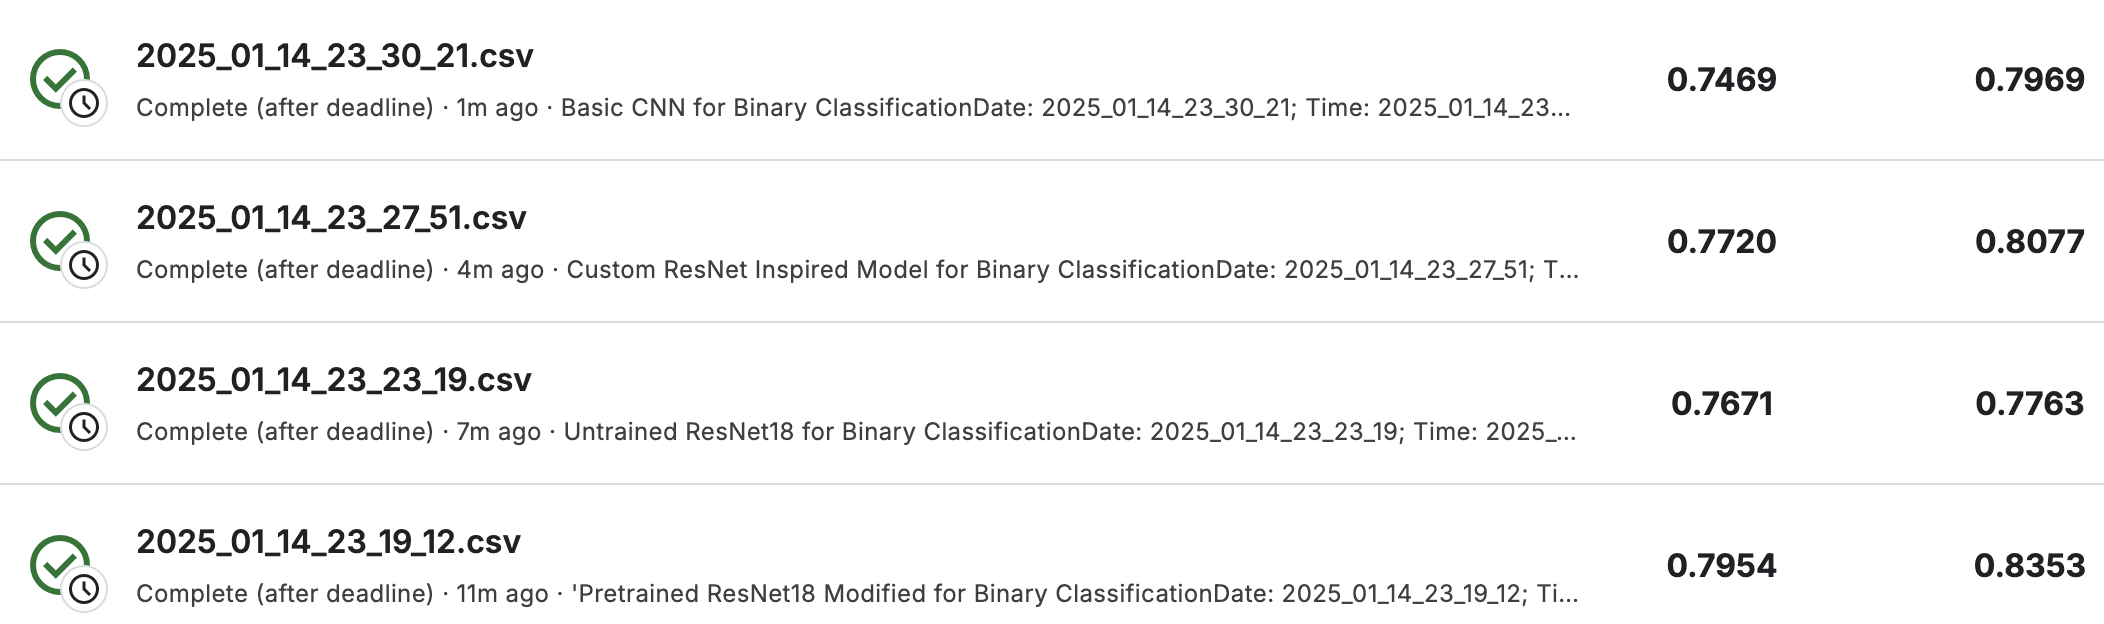

# CNN
CNN models are the best for this task. Even the simple CNN model achieved a good score. The simple CNN model even outscored the more simple untrained ResNet18 model

# Pretrained Models
Retraing a pretrained model gave the best results overall. An advantage of pretrained models that was not explored here is reduced training time **if** layers are frozen. In all cases I retrained the entire set of weights.

Regardless, the weights from pretrained models are a good starting point for training.

# Data Augmentation
I did not test without data augmentation so I can not compare. In general, we should expect that data augmentation will improve performance. In particular, augmentation should improve robustness and reduce overfitting.

# Training Time
At first, I tried training on the entire dataset. This was very slow and became a tedious process. I found that even a very small sample like 8000 gave performance close to training on the full set of samples.


In [20]:
# Binary Cross-Entropy Loss for binary classification
criterion = nn.BCEWithLogitsLoss()

# SGD optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [21]:
num_epochs = 100
epoch_reached = 0
early_stopping = EarlyStopping(patience=early_stopping_patience, delta=early_stopping_delta)

from torch.amp import GradScaler, autocast

scaler = GradScaler("cuda")

for epoch in range(num_epochs):
    epoch_reached += 1
    print(f"Epoch {epoch+1}/{num_epochs}")

    model.train()
    running_loss = 0.0


    for i, data in enumerate(train_loader):
        if i % batch_status_interval == 0:
          print(f"\tBatch {i+1}/{len(train_loader)}")

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with autocast('cuda'):  # Enables mixed precision
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    print(f"\tTraining Loss: {running_loss / len(train_loader)}")
    model.eval()
    val_loss = 0.0
    correct = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs.squeeze(), labels).item()

            # don't forgot sigmoid because we used BCEWithLogitsLoss
            predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).long()
            correct += (predicted == labels).sum().item()
    print(f"\tValidation Loss: {val_loss / len(val_loader)}")
    print(f"\tValidation Accuracy: {correct / len(val_dataset)}")

    # Early stopping logic
    early_stopping(correct / len(val_dataset), model)

    print(f"\tEarly Stopping Counter: {early_stopping.counter}")

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

# Load the best model weights
model.load_state_dict(early_stopping.get_best_weights())
message += f"Model Layout: {model}; "



Epoch 1/100
	Batch 1/50
	Batch 11/50
	Batch 21/50
	Batch 31/50
	Batch 41/50
	Training Loss: 0.6759301424026489
	Validation Loss: 0.65892971937473
	Validation Accuracy: 0.62875
[EarlyStopping] First epoch: setting best_acc=0.62875
	Early Stopping Counter: 0
Epoch 2/100
	Batch 1/50
	Batch 11/50
	Batch 21/50
	Batch 31/50
	Batch 41/50
	Training Loss: 0.6348755300045014
	Validation Loss: 0.6045947349988497
	Validation Accuracy: 0.7
[EarlyStopping] Current val_acc=0.70000; best_acc + delta=0.63375; Improvement? True
	Early Stopping Counter: 0
Epoch 3/100
	Batch 1/50
	Batch 11/50
	Batch 21/50
	Batch 31/50
	Batch 41/50
	Training Loss: 0.5830922484397888
	Validation Loss: 0.5597213598398062
	Validation Accuracy: 0.726875
[EarlyStopping] Current val_acc=0.72688; best_acc + delta=0.70500; Improvement? True
	Early Stopping Counter: 0
Epoch 4/100
	Batch 1/50
	Batch 11/50
	Batch 21/50
	Batch 31/50
	Batch 41/50
	Training Loss: 0.5613926726579667
	Validation Loss: 0.5389922582186185
	Validation Accura

In [22]:
torch.save(model.state_dict(), current_time + '.pth')

In [23]:
model.load_state_dict(torch.load(current_time + '.pth'))
model.eval()

# final results
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).long()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_acc = correct / total
print(f"Validation Accuracy: {val_acc}")

message += f"Validation Accuracy: {val_acc}; "

<ipython-input-23-29c9f223e00b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(current_time + '.pth'))


Validation Accuracy: 0.8275


In [24]:
# def predict_image(image_path, model, transform, device):
#     image = Image.open(image_path).convert('RGB')
#     image = predict_transform(image).unsqueeze(0).to(device)
#     output = model(image).item()
#     # tensor then sigmoid
#     output = torch.tensor(output)
#     output = 1 / (1 + torch.exp(-output))
#     return '1' if output > 0.5 else '0'

# # for each image in test dir, predict and produce CSV with results
# import os
# import pandas as pd
# from PIL import Image

# results = []

# for filename in os.listdir(test_dir):
#     if filename.endswith('.tif'):
#         image_path = os.path.join(test_dir, filename)
#         prediction = predict_image(image_path, model, predict_transform, device)
#         id_no_ext = os.path.splitext(filename)[0]
#         results.append({'id': id_no_ext, 'label': prediction})

# results = pd.DataFrame(results)

# results.to_csv(model_name + '.csv', index=False)

In [25]:
class InferenceDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [
            f for f in os.listdir(image_dir) if f.endswith('.tif')
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)

        # Return (image, filename) so we can keep track of which output belongs to which file
        return image, img_name

# Create the dataset and dataloader
inference_dataset = InferenceDataset(
    image_dir=test_dir,
    transform=predict_transform
)
inference_loader = DataLoader(
    inference_dataset,
    batch_size=batch_size,    # or another batch size
    shuffle=False,
    num_workers=num_workers,    # depends on your system
    pin_memory=True   # optional, can help on CUDA
)


In [26]:

# Now do inference in batches
model.eval()
results = []

with torch.no_grad():
    for batch_images, filenames in inference_loader:
        batch_images = batch_images.to(device)
        outputs = model(batch_images)

        # For a binary classification example with BCEWithLogitsLoss:
        preds = torch.sigmoid(outputs).squeeze(dim=1)
        preds = (preds > 0.5).long().cpu().numpy()

        # Store results
        for filename, pred in zip(filenames, preds):
            id_no_ext = os.path.splitext(filename)[0]
            results.append({'id': id_no_ext, 'label': pred})

# Convert to a DataFrame and save
import pandas as pd
df = pd.DataFrame(results)
df.to_csv(current_time + '.csv', index=False)


In [27]:
import shlex
message += f'\nEpoch Reached: {epoch_reached}; '
message = shlex.quote(message)

exit_code = os.system(f"kaggle competitions submit -c histopathologic-cancer-detection -f {current_time + '.csv'} -m {message}")

if exit_code == 0:
    print("Submission successful")
else:
    print("Submission failed")

Submission successful


In [28]:
# shutdown
# from google.colab import runtime
# runtime.unassign()